# <center> <span style="font-family: ClearSans-Bold, sans-serif; color:#7060eb">Experiment Tracking</span> </center>

 <span style="font-family: ClearSans, sans-serif; color:navyblue">Author: <a href="https://github.com/jnsofini" title="GitHub link">https://github.com/jnsofini</a></span>

<div class="alert alert-block alert-info">
 <span style="font-family: ClearSans, sans-serif; color:navyblue"><b>Credit:</b> This notebook contains refactored <a href="https://github.com/DataTalksClub/mlops-zoomcamp/blob/main/01-intro/duration-prediction.ipynb" title="Duration Prediction">code</a> from the course <a href="https://github.com/DataTalksClub/mlops-zoomcamp/tree/main" title="Machine Learning Operations">Machine Learning Operations Zoom Camp</a> (Data Talks) and Alexey. This notebook runs through the process in chapter one by using modules. The code is imported from src. The goal of this notebook is to train a simple model for predicting the duration of a ride lecture video. </a>
 </div>

__Used packages__

In [1]:
import pandas as pd
from pathlib import Path
from typing import Dict, List

In [2]:
%load_ext autoreload
%autoreload 2
from src import preprocessing, train

### <span style="font-family: ClearSans-Bold, sans-serif; color:#7060eb">Data preprocessing</span>

In [3]:
train_data_dir = "../01-intro/refactored/data/preprocess"

In [4]:
categorical = ['PULocationID', 'DOLocationID']
TARGET = 'duration'

For learning purposes, we will sample just 100K data points and used for the model building and 25K for validation.

In [5]:
def read_data():
    cols = categorical + [TARGET]
    train_data = (
        pd.read_parquet(Path(train_data_dir)/"train.parquet")[cols].sample(
        n=100_000
        ) 
        )
    test_data = (
        pd.read_parquet(Path(train_data_dir)/"test.parquet")[cols].sample(
        n=25_000 
        )
        )
    
    return train_data, test_data

### <span style="font-family: ClearSans-Bold, sans-serif; color:#7060eb">Load data</span>

In [6]:
train_data, test_data = read_data()

In [7]:
train_data.head()

,PULocationID,DOLocationID,duration
1736204,68,170,23.583333
1300169,237,41,13.483333
2126321,237,186,13.116667
515728,211,66,8.133333
1409585,164,249,8.533333


In [9]:
import seaborn as sns

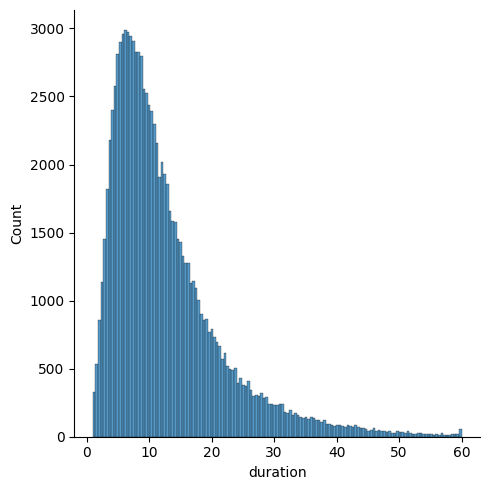

In [10]:
sns.displot(train_data.duration,)

Prepare to train a model

In [12]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [8]:
import mlflow

In [14]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/home/fini/github-projects/mlops/02-experiment-tracking/mlruns/1', creation_time=1685124649068, experiment_id='1', last_update_time=1685124649068, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

Train logistic regresson model

In [15]:
def train_linear_regression_model(df_train:pd.DataFrame, df_test:pd.DataFrame, categorial_features: List[str], target: str = "duration"):
    """Train a Linear Regression and calculate the RMSE on the validation dataframe

    Args:
        df_train (pd.DataFrame): Training data
        df_test (pd.DataFrame): Test data
        categorial_features (List[str]): List of categorical features
        target (str, optional): Target column. Defaults to "duration".

    Returns:
        Dict[str, float]: Dict of mse for train and test
    """ 
    
    dv = DictVectorizer()   
    train_dicts = df_train[categorial_features].to_dict(orient='records')
    test_dicts = df_test[categorial_features].to_dict(orient='records')
    
    X_train = dv.fit_transform(train_dicts)
    X_test = dv.transform(test_dicts)
    
    y_train = df_train[target].values
    y_test = df_test[target].values

    lr = LinearRegression()
    lr.fit(X_train, y_train)

    y_pred_train = lr.predict(X_train)
    y_pred_test = lr.predict(X_test)


    mse = {
        "train-mse": mean_squared_error(y_train, y_pred_train, squared=False),
        "test-mse": mean_squared_error(y_test, y_pred_test, squared=False)
        }
    
    return dv, lr, mse 

### <span style="font-family: ClearSans-Bold, sans-serif; color:#7060eb">Model Training</span>

In [24]:
dv, model,  mse = train_linear_regression_model(
    train_data, 
    test_data, 
    categorial_features=categorical, 
    target=TARGET
    )

In [25]:
print(f'Train mse is : {mse["train-mse"]:.2f}')
print(f'Train mse is : {mse["test-mse"]:.2f}')

Train mse is : 6.99
Train mse is : 7.79


In [31]:
import pickle

In [28]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, model), f_out)

In [23]:
dv = DictVectorizer()   
train_dicts = train_data[categorical].to_dict(orient='records')
test_dicts = test_data[categorical].to_dict(orient='records')

X_train = dv.fit_transform(train_dicts)
X_test = dv.transform(test_dicts)

y_train = train_data[TARGET].values
y_test = test_data[TARGET].values

We can see that we don't keep track of the parameters. We can log what we have with MLflow.

In [24]:
def train_linear_regression(
        x_train: pd.DataFrame, 
        y_train,
        x_test: pd.DataFrame, 
        y_test
        ):
    """Train a Linear Regression and calculate the RMSE on the validation dataframe

    """ 


    with mlflow.start_run(run_name="Linear reg", tags={"algo-type": "LinearRegression"}):

        mlflow.set_tag("developer", "Fini")

        mlflow.log_param("train-data-path", "green_tripdata_2021-01.parquet")
        mlflow.log_param("valid-data-path", "green_tripdata_2021-02.parquet")

        lr = LinearRegression()
        lr.fit(X_train, y_train)

        y_pred_train = lr.predict(x_train)
        y_pred_test = lr.predict(x_test)


        mse = {
            "train-mse": mean_squared_error(y_train, y_pred_train, squared=False),
            "test-mse": mean_squared_error(y_test, y_pred_test, squared=False)
            }
        for name, mse_value in mse.items():
            mlflow.log_param(name, mse_value)

        mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")
    
    return dv, lr, mse 

In [26]:
dv, logreg,  mse = train_linear_regression(
    x_train=X_train,
        y_train=y_train,
        x_test=X_test,
        y_test=y_test
)

In [33]:
def train_lasso(
        x_train: pd.DataFrame, 
        y_train,
        x_test: pd.DataFrame, 
        y_test,
        alpha=1
        ):
    """Train a Lasso Regression and calculate the RMSE on the validation dataframe

    """ 


    with mlflow.start_run(run_name="Lasso regressiion", tags={"algo-type": "lasso()"}):

        mlflow.set_tag("developer", "Fini")

        mlflow.log_param("train-data-path", "green_tripdata_2021-01.parquet")
        mlflow.log_param("valid-data-path", "green_tripdata_2021-02.parquet")
        mlflow.log_param("alpha", alpha)


        lr = Lasso(alpha=alpha)
        lr.fit(X_train, y_train)

        y_pred_train = lr.predict(x_train)
        y_pred_test = lr.predict(x_test)


        mse = {
            "train-mse": mean_squared_error(y_train, y_pred_train, squared=False),
            "test-mse": mean_squared_error(y_test, y_pred_test, squared=False)
            }
        for name, mse_value in mse.items():
            mlflow.log_param(name, mse_value)

        with open('models/lasso_reg.bin', 'wb') as f_out:
            pickle.dump((dv, lr), f_out)

        mlflow.log_artifact(local_path="models/lasso_reg.bin", artifact_path="models_pickle")
    
    return lr, mse 

In [36]:
lasso_reg,  mse = train_lasso(
    x_train=X_train,
        y_train=y_train,
        x_test=X_test,
        y_test=y_test,
        alpha=5
)

Lets train a more complex model: xgboost

In [37]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [38]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_test, label=y_test)

In [42]:
def objective(params):
    """Objective function to minimize

    Args:
        params (dict): Set of parameters for the specific run

    Returns:
        dict: loss and status
    """
    with mlflow.start_run(run_name="optimization"):
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [43]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[14:01:50] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:13.79728                          
[1]	validation-rmse:11.93783                          
[2]	validation-rmse:10.63380                          
[3]	validation-rmse:9.72833                           
[4]	validation-rmse:9.12016                           
[5]	validation-rmse:8.66300                           
[6]	validation-rmse:8.36773                           
[7]	validation-rmse:8.16292                           
[8]	validation-rmse:8.00850                           
[9]	validation-rmse:7.90843                           
[10]	validation-rmse:7.74120                          
[11]	validation-rmse:7.68266                          
[12]	validation-rmse:7.63228                          
[13]	validation-rmse:7.58507                          
[14]	validation-rmse:7.55599                          
[15]	validation-rmse:7.51426                          
[

KeyboardInterrupt: 

Use parameters from the best model. We can leverage autolog. It allows to log a lot of params with just one line of code.

In [46]:
with mlflow.start_run(run_name="Optimal Params", tags={"Logging": "autolog-with params"}):

    mlflow.xgboost.autolog(disable=False)
    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }

    mlflow.log_params(best_params)
    mlflow.log_param("train-data-path", "green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "green_tripdata_2021-02.parquet")

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=100,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor2.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor2.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

[14:31:59] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:15.26634
[1]	validation-rmse:14.28093
[2]	validation-rmse:13.41698
[3]	validation-rmse:12.65962
[4]	validation-rmse:11.98096
[5]	validation-rmse:11.38860
[6]	validation-rmse:10.87358
[7]	validation-rmse:10.43235
[8]	validation-rmse:9.99190
[9]	validation-rmse:9.65500
[10]	validation-rmse:9.36172
[11]	validation-rmse:9.10613
[12]	validation-rmse:8.88817
[13]	validation-rmse:8.62801
[14]	validation-rmse:8.46419
[15]	validation-rmse:8.32362
[16]	validation-rmse:8.13568
[17]	validation-rmse:8.02896
[18]	validation-rmse:7.93104
[19]	validation-rmse:7.84591
[20]	validation-rmse:7.77256
[21]	validation-rmse:7.70757
[22]	validation-rmse:7.64889
[23]	validation-rmse:7.53400
[24]	validation-rmse:7.49426
[25]	validation-rmse:7.44779
[26]	validation-rmse:7.41025
[27]	validation-rmse:7.38091
[28]	validation-rmse:7.28904
[29]	validation-rmse:7.26624
[30]	validati

2023/05/26 14:32:35 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.


In [44]:
with mlflow.start_run(run_name="Optimal Params"):

    mlflow.xgboost.autolog(disable=True)
    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

[14:14:10] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:15.26634
[1]	validation-rmse:14.28093
[2]	validation-rmse:13.41698
[3]	validation-rmse:12.65962
[4]	validation-rmse:11.98096
[5]	validation-rmse:11.38860
[6]	validation-rmse:10.87358
[7]	validation-rmse:10.43235
[8]	validation-rmse:9.99190
[9]	validation-rmse:9.65500
[10]	validation-rmse:9.36172
[11]	validation-rmse:9.10613
[12]	validation-rmse:8.88817
[13]	validation-rmse:8.62801
[14]	validation-rmse:8.46419
[15]	validation-rmse:8.32362
[16]	validation-rmse:8.13568
[17]	validation-rmse:8.02896
[18]	validation-rmse:7.93104
[19]	validation-rmse:7.84591
[20]	validation-rmse:7.77256
[21]	validation-rmse:7.70757
[22]	validation-rmse:7.64889
[23]	validation-rmse:7.53400
[24]	validation-rmse:7.49426
[25]	validation-rmse:7.44779
[26]	validation-rmse:7.41025
[27]	validation-rmse:7.38091
[28]	validation-rmse:7.28904
[29]	validation-rmse:7.26624
[30]	validati

/home/fini/anaconda3/envs/mlops/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


To log an artifact, we need to first have it saved locally. Once it is saved, we simply pass the location to the log_artifact function and the path in MLflow file system.

In [ ]:
def _log_artifact(artifact, local_path="models/preprocessor.b", mlflow_path="preprocessor"):
    with open(local_path, "wb") as f_out:
        pickle.dump(artifact, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path=mlflow_path)

In [47]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "../data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "../data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)